In [1]:
DATA_DIR = 'C:/Users/ARYAN PALIMKAR/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3'

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle = True, pin_memory = True)

In [6]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [8]:
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

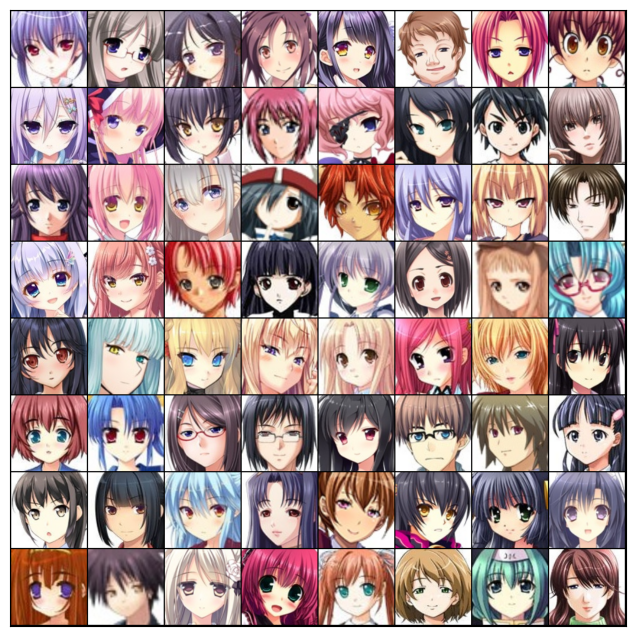

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)


In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

# **Discriminator** **Model**

In [ ]:
discriminator = nn.Sequential(
    #from 3 x 128 x 128 to 32 x 64 x 64
    nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Dropout2d(0.2),
    
    nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Dropout2d(0.2),

    # from 64 x 32 x 32 to 128 x 16 x 16
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Dropout2d(0.2),

    # from 256 x 8 x 8 to 128 x 4 x 4
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Model

In [ ]:
latent_size = 256

generator = nn.Sequential(
    #in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 128x4x4

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 64x8x8

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 32x16x16

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 16x32x32

    nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    #out: 8x64x64 

    nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()

    #out: 3 x 128 x 128
)

#### Random latent vectors

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

In [25]:
def sample_latent(batch_size, latent_size):
    return torch.empty(batch_size, latent_size, 1, 1, device=device).uniform_(-1, 1)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [29]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
discriminator.to(device)
generator.to(device)

In [ ]:
from tqdm import tqdm

def train_discriminator(real_images, optimizer_d):
    optimizer_d.zero_grad()

    # Gaussian Noise
    real_images = real_images + 0.05 * torch.randn_like(real_images)

    # Discriminator on real images
    real_preds = discriminator(real_images)
    real_targets = torch.full((real_images.size(0), 1), 0.9, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    # Generate fake images
    latent = sample_latent(batch_size, latent_size)
    with torch.no_grad():
        fake_images = generator(latent)

    # Discriminator on fake images
    fake_preds = discriminator(fake_images)
    fake_targets = torch.rand_like(fake_preds) * 0.1
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    # Total discriminator loss
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_d.step()

    return loss.item()


def train_generator(optimizer_g):
    optimizer_g.zero_grad()

    # Generate fake images
    latent = sample_latent(batch_size, latent_size)
    fake_images = generator(latent)

    # Pass fake images to discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator
    loss.backward()
    optimizer_g.step()

    return loss.item()


def fit(epochs, start_ind=1):
    losses_g, losses_d = [], []

    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))

    for epoch in range(epochs):
        loss_d_total, loss_g_total = 0, 0
        num_batches = len(train_dl)

        for real_images, i in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            
            real_images = real_images.to(device)

            for _ in range(2):
                loss_d = train_discriminator(real_images, optimizer_d)

            loss_g = train_generator(optimizer_g)

            loss_d_total += loss_d
            loss_g_total += loss_g

        # Record losses
        losses_d.append(loss_d_total / num_batches)
        losses_g.append(loss_g_total / num_batches)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss G: {losses_g[-1]:.4f} | Loss D: {losses_d[-1]:.4f}")

        # Save generated samples
        with torch.no_grad():
            save_samples(epoch + start_ind, fixed_latent, show=False)
    return losses_g, losses_d

In [ ]:
history = fit(epochs=100)

In [ ]:
torch.save(generator.state_dict(), 'generator_weights.pth')
torch.save(discriminator.state_dict(), 'discriminator_weights.pth')